In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from xgboost import XGBClassifier, plot_importance
import shap
import matplotlib.pyplot as plt


In [24]:

# 1. Load & preprocess dataset

df = pd.read_csv("churn_data.csv")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

X = df.drop(['customerID','Churn'], axis=1)
y = df['Churn']

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [25]:
# 2. Handle class imbalance

neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

In [26]:
# 3. Train XGBoost

xgb = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train, y_train)

C:\Users\Abid.MD\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [11:27:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [27]:
# 4. Predict probabilities

y_pred_proba = xgb.predict_proba(X_test)[:,1]

In [28]:
# 5. Automatic threshold tuning

thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresh))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best threshold = {best_threshold:.2f} with F1-score = {f1_scores[best_idx]:.3f}")

Best threshold = 0.43 with F1-score = 0.622


In [29]:
# Use best threshold for predictions
y_pred = (y_pred_proba >= best_threshold).astype(int)

In [30]:
# 6. Evaluation

print("Classification Report (best threshold):")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))

Classification Report (best threshold):
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1035
           1       0.53      0.75      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.76      0.77      1409

ROC-AUC: 0.8315675940995633


<Figure size 1000x600 with 0 Axes>

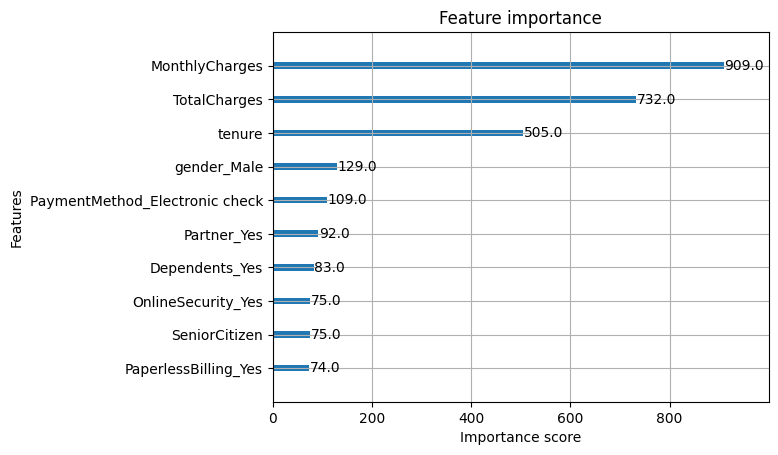

In [31]:
# 7. Feature importance

plt.figure(figsize=(10,6))
plot_importance(xgb, max_num_features=10)
plt.show()